In [1]:
from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

## Pyro inference over the mixed_simulator

In [2]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS
import torch 

def model():
    # prior
    rho = pyro.sample("rho", dist.Beta(torch.tensor([2.0]), torch.tensor([2.0])))
    rate = pyro.sample("rate", dist.Gamma(torch.tensor([1.]), torch.tensor([.5])))
    
    # simulator
    choices = pyro.sample("choices", dist.Binomial(probs=rho))
    rts = pyro.sample("rts", dist.InverseGamma(concentration=2 * torch.ones_like(rate), rate=rate))
    
    return torch.cat((rts, choices))

# conditioning
def conditioned_model(model, data):
    return poutine.condition(model, data={"rts": data[:, 0], "choices": data[:, 1]})()

# generate observation
num_trials= 100
data = model().repeat(num_trials, 1)
data.shape

# run MCMC
nuts_kernel = NUTS(conditioned_model, jit_compile=False)
mcmc = MCMC(
    nuts_kernel,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
)
mcmc.run(model, data)
mcmc.summary(prob=0.5)

Sample: 100%|████████████████████████████████████████| 1100/1100 [00:11, 94.69it/s, step size=3.71e-01, acc. prob=0.980]                                                                                    


                mean       std    median     25.0%     75.0%     n_eff     r_hat
   rate[0]      0.58      0.04      0.58      0.55      0.61    576.76      1.00
    rho[0]      0.98      0.01      0.98      0.98      0.99    634.66      1.00

Number of divergences: 0


## Pyro inference with mixed_simulator wrapped in custom distribution 

By wrapping the mixed simulator into a Pyro Distribution we can treat it as such in the common Pyro `model` framework:

In [3]:
from pyro.distributions import constraints

class MixedSimulator(dist.Distribution):
    
    # Important: we need to define constraints and the support.
    arg_constraints = {
        "rho": constraints.interval(0, 1),
        "rate": constraints.positive,
    }
    # Note: we a discrete support for the choices.
    support = constraints.independent(
                constraints.cat([constraints.positive, constraints.integer_interval(0, 1)], dim=1),
                reinterpreted_batch_ndims=1,
        )
    
    def __init__(self, rho, rate, validate_args=None):
        self._binomial = dist.Binomial(probs=rho)
        self._inverse_gamma = dist.InverseGamma(concentration=2 * torch.ones_like(rate), rate=rate)

    @property
    def rho(self):
        return self._binomial.probs

    @property
    def rate(self):
        return self._inverse_gamma.rate

    def sample(self, sample_shape=torch.Size()):
        choices = self._binomial.sample(sample_shape)
        rts = self._inverse_gamma.sample(sample_shape)
        
        return torch.cat((rts, choices), dim=-1)
    
    def log_prob(self, x):
        rts, choices = x.T
        return self._inverse_gamma.log_prob(rts) + self._binomial.log_prob(choices)

### Pyro plate notation enables fast changing of number of trials!

Note how the posterior centers on the true params as we increase `num_trials`.

In [5]:
def model(trials=None):
    # prior
    rho = pyro.sample("rho", dist.Beta(torch.tensor([2.0]), torch.tensor([2.0])))
    rate = pyro.sample("rate", dist.Gamma(torch.tensor([1.]), torch.tensor([.5])))
    
    num_trials = 1 if trials is None else len(trials) 
    
    with pyro.plate("data", num_trials):
        return pyro.sample("obs", MixedSimulator(rho, rate), obs=trials)


# generate observation
num_trials= 1000
trials = MixedSimulator(rho=torch.tensor([0.5]), rate=torch.tensor([1.0])).sample((num_trials,))

# run MCMC
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(
    nuts_kernel,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
)
mcmc.run(trials)
mcmc.summary(prob=0.5)

Sample: 100%|███████████████████████████████████████| 1100/1100 [00:07, 155.37it/s, step size=7.88e-01, acc. prob=0.927]                                                                                    


                mean       std    median     25.0%     75.0%     n_eff     r_hat
   rate[0]      1.01      0.02      1.01      1.00      1.03    967.41      1.00
    rho[0]      0.51      0.02      0.51      0.50      0.52    523.97      1.00

Number of divergences: 0


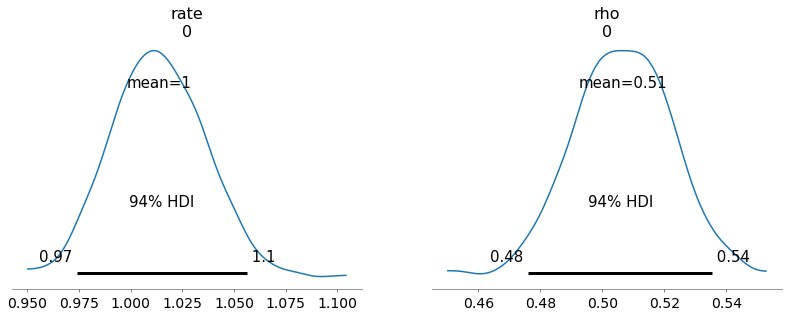

In [6]:
import arviz as az

idata = az.from_pyro(mcmc)
az.plot_posterior(idata);

## Can we do the same with the MNLE object? 

In [7]:
# Toy simulator for mixed data
def mixed_simulator(theta):
    rate, ps = theta[:, :1], theta[:, 1:]

    choices = Binomial(probs=ps).sample()
    rts = InverseGamma(concentration=2 * torch.ones_like(rate), rate=rate).sample()

    return torch.cat((rts, choices), dim=1)


# Define independent priors for each dimension.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),  # rate
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),  # rho
    ],
    validate_args=False,
)

In [13]:
# Generate training data and train MNLE.
num_simulations = 10000
theta = prior.sample((num_simulations,))
x = mixed_simulator(theta)

trainer = MNLE(prior)
likelihood_estimator = trainer.append_simulations(theta, x).train()

/Users/janbolts/opt/anaconda3/envs/mnle/lib/python3.8/site-packages/sbi/neural_nets/mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 65 epochs.

In [28]:
class MNLESimulator(dist.Distribution):
    
    # Important: we need to define constraints and the support.
    arg_constraints = {
        "rate": constraints.positive,
        "rho": constraints.interval(0, 1),
    }
    # Note: we a discrete support for the choices.
    support = constraints.independent(
                constraints.cat([constraints.positive, constraints.integer_interval(0, 1)], dim=1),
                reinterpreted_batch_ndims=1,
        )
    
    def __init__(self, rho, rate, mnle, validate_args=None):
        self._theta = torch.cat((torch.atleast_2d(rate), torch.atleast_2d(rho)), dim=1)
        self._mnle = mnle
    
    @property
    def rate(self):
        return self._theta[:, 0]
        
    @property
    def rho(self):
        return self._theta[:, 1]

    def sample(self, sample_shape=torch.Size()):
        sample_shape = torch.Size(sample_shape)
        return self._mnle.sample(theta=self._theta, num_samples=sample_shape.numel())
    
    def log_prob(self, x):
        return self._mnle.log_prob(x, self._theta.repeat(x.shape[0], 1))

In [29]:
mms = MNLESimulator(rho=torch.tensor([0.5]), rate=torch.tensor([1.0]), mnle=likelihood_estimator)

In [32]:
def model(trials=None):
    # prior
    rho = pyro.sample("rho", dist.Beta(torch.tensor([2.0]), torch.tensor([2.0])))
    rate = pyro.sample("rate", dist.Gamma(torch.tensor([1.]), torch.tensor([.5])))
    
    num_trials = 1 if trials is None else len(trials) 
    
    with pyro.plate("data", num_trials):
        return pyro.sample("obs", MNLESimulator(rho, rate, mnle=likelihood_estimator), obs=trials)


# generate observation
num_trials= 1000
trials = MixedSimulator(rho=torch.tensor([0.5]), rate=torch.tensor([1.0])).sample((num_trials,))

# run MCMC
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(
    nuts_kernel,
    num_samples=1000,
    warmup_steps=100,
    num_chains=1,
)
mcmc.run(trials)
mcmc.summary(prob=0.5)

Sample: 100%|████████████████████████████████████████| 1100/1100 [03:04,  5.97it/s, step size=5.10e-01, acc. prob=0.966]                                                                                    


                mean       std    median     25.0%     75.0%     n_eff     r_hat
   rate[0]      1.04      0.02      1.04      1.03      1.06    607.94      1.00
    rho[0]      0.52      0.01      0.53      0.52      0.53    492.12      1.00

Number of divergences: 0


/Users/janbolts/opt/anaconda3/envs/mnle/lib/python3.8/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


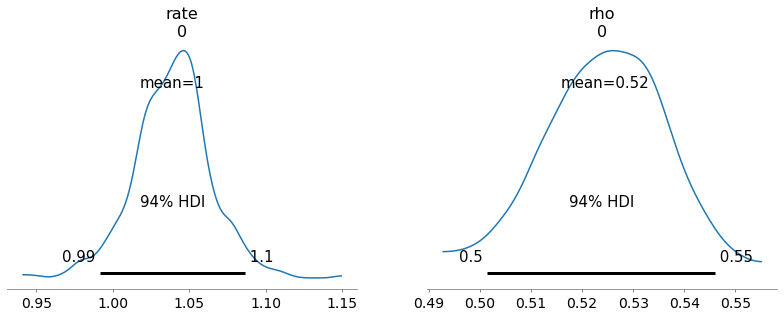

In [33]:
idata = az.from_pyro(mcmc)
az.plot_posterior(idata);